## Giovanni Palma
# L’ascesa e l’influenza dei videogiochi indie nel XXI secolo

# Motivazioni e domande poste
- Quale è la situazione attuale dei videogiochi?
- Che cosa viene utilizzato per sviluppare i videogiochi?
- Come è variato nel tempo il mercato videoludico?
- Vale la pena investire tempo e denaro nello sviluppo di videogiochi indie


# Dataset e servizi usati
- IGDB API: Dataset principale, usato per i generi, i motori grafici, date di uscita
- Steam Dataset May 2024: Usato per le recensioni utente e score utente
- IsThereAnyDeal API: Per lo storico dei prezzi di un videogioco

# Che cos'è un videogioco indie?
I giochi indie, abbreviazione di "indipendenti", sono videogiochi sviluppati da piccoli team o singoli individui, spesso senza il supporto tecnico e finanziario di grandi editori, in contrasto con i giochi non indie (erroneamente detti «AAA»).

In [41]:
# Codice iniziale, comune per molte cell
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import igdb
import utils
import os
from dotenv import load_dotenv

from datetime import date
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

# Carico il file .env dove memorizzo le API keys
load_dotenv()
sns.set_style("whitegrid") # Style generale di seaborn

In [42]:
# Creazione dell'oggetto IGDB_Wrapper che userò per fetchare i dati
IGDB_CLIENT_ID = os.getenv("IGDB_CLIENT_ID")
IGDB_CLIENT_SECRET = os.getenv("IGDB_CLIENT_SECRET")
igdb_wrapper = igdb.IGDBWrapper(IGDB_CLIENT_ID, IGDB_CLIENT_SECRET)


igdb_df = pd.read_csv("data/igdb.csv") # Importazione del dataset principale 
igdb_df = igdb_df[igdb_df['category'].isin([0])] # Considero solo i giochi. Non considero remastered, DLC, remake o altro


# Fix delle colonne genres, first_release_date che uso spesso in più grafici
igdb_df['genres'] = igdb_df['genres'].apply(utils.str_to_list) # Converto i generi da stringa a lista. Esempio: "[2, 5, 12]" -> [2, 5, 12]
igdb_df['first_release_date'] = pd.to_datetime(igdb_df['first_release_date'],unit='s') # Converto la data da stringa a datetime

# Raccolta del mapping dei generi
igdb_genres_map = {genre['id']: genre['name'] for genre in igdb_wrapper.genres()}
genres_rename = {
    'Real Time Strategy (RTS)': 'RTS', 
    'Turn-based strategy (TBS)': 'TBS',
    "Hack and slash/Beat 'em up": "Hack'n'Slash",
    "Role-playing (RPG)": "RPG",
    "Card & Board Game": "Board Game",
}
for key, old_name in igdb_genres_map.items():
    if old_name in genres_rename:
        igdb_genres_map[key] = genres_rename[old_name]

# Situazione attuale dei videogiochi indie

## Numero di videogiochi indie

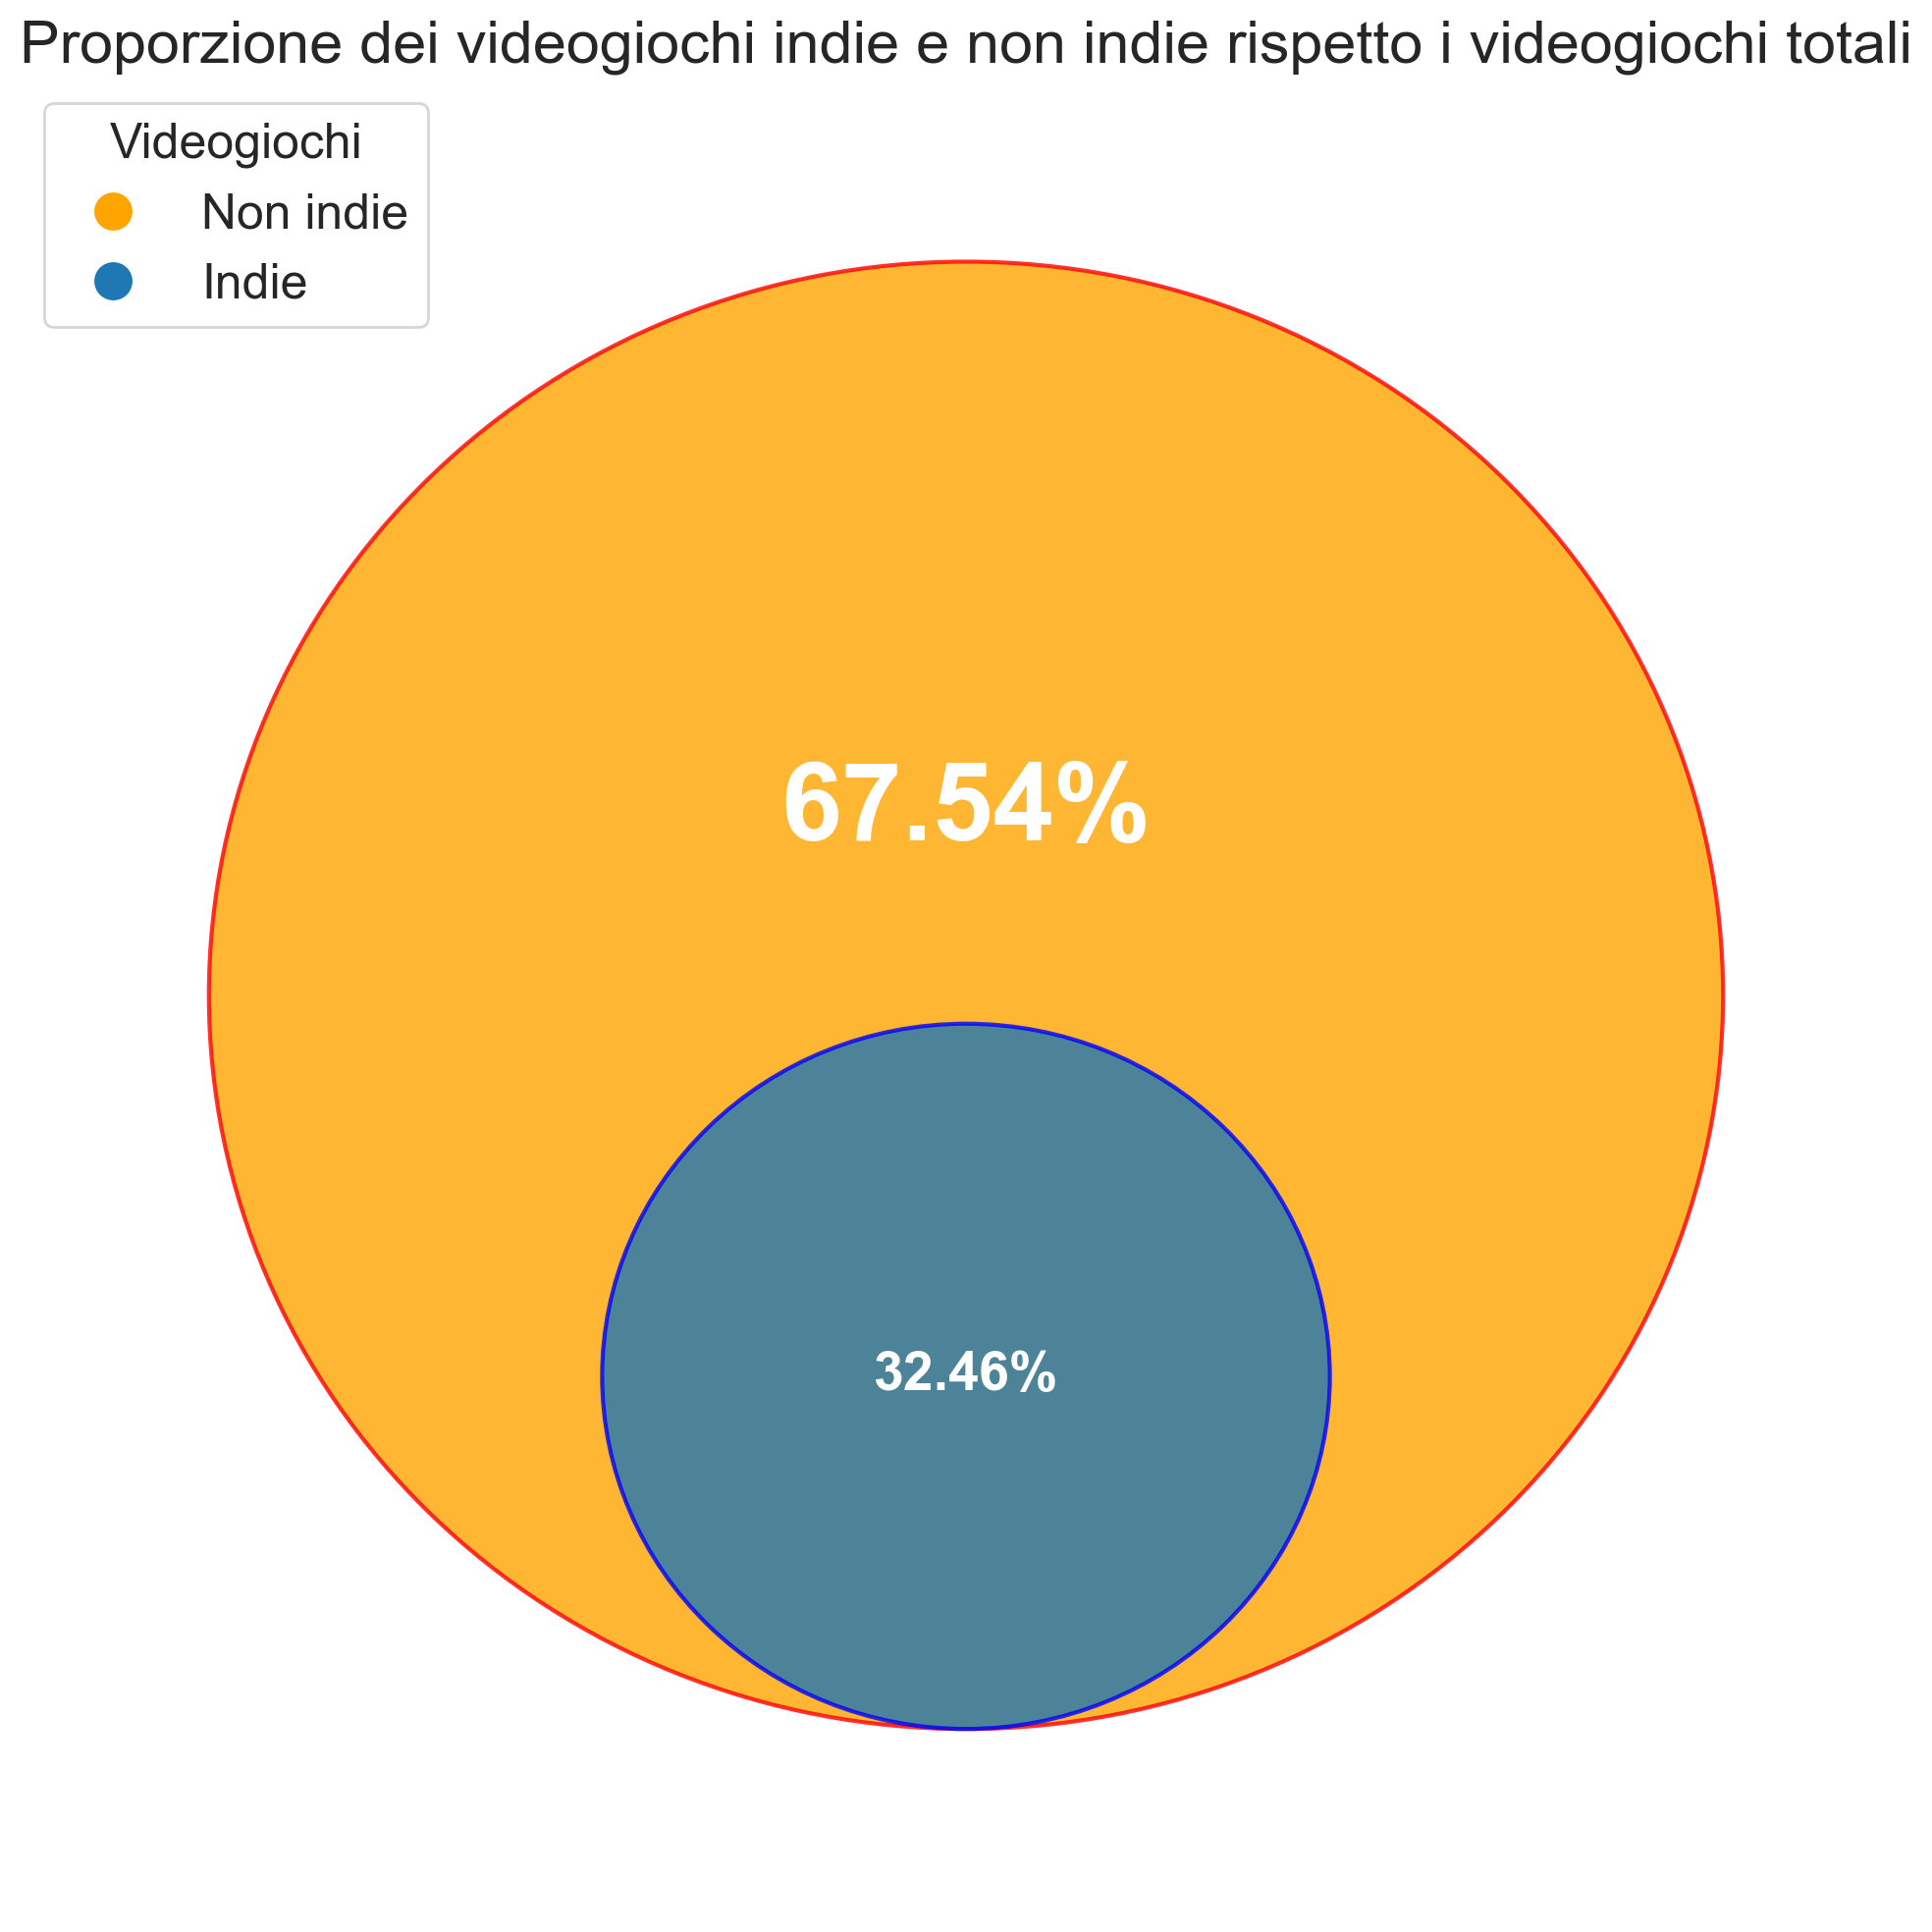

In [43]:
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

count_giochi = igdb_df.shape[0]
count_indie = igdb_df[igdb_df['genres'].apply(lambda x: 32 in x)].shape[0]
count_non_indie = count_giochi - count_indie

size_indie = (count_indie / count_non_indie)*0.4
pos_y_indie = 0.1 + size_indie

perc_indie = count_indie / count_giochi
perc_non_indie = 1 - perc_indie

fig, ax = plt.subplots(figsize=(10,10))
insieme_non_indie = Circle((0.5, 0.5), 0.4, fill=True, edgecolor='red', facecolor='orange', linewidth=1.5, alpha=0.8)
insieme_indie = Circle((0.5, pos_y_indie), size_indie, fill=True, edgecolor='blue', facecolor="tab:blue", linewidth=1.5, alpha=0.8)

ax.add_patch(insieme_non_indie)
ax.add_patch(insieme_indie)

ax.annotate(f'{perc_non_indie:.2%}', (0.5, 0.6), ha='center', va='center', color='white', fontweight='bold', fontsize=40)
ax.annotate(f'{perc_indie:.2%}', (0.5, pos_y_indie), ha='center', va='center', color='white', fontweight='bold', fontsize=20)

# https://stackoverflow.com/questions/11423369/matplotlib-legend-circle-markers
legend_elements = [
    Line2D([0], [0], marker='o', color='white', markerfacecolor='orange', markersize=15, label='Non indie'),
    Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:blue', markersize=15, label='Indie')
]

ax.legend(handles=legend_elements,
          loc='upper left',
          fontsize=18,  # Dimensione del testo
          title="Videogiochi",
          title_fontsize=18,
          frameon=True) 

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title("Proporzione dei videogiochi indie e non indie rispetto i videogiochi totali",fontsize=22)
ax.axis('off')
plt.tight_layout()
plt.show()
#fig.savefig("imgs/grafici/fig1.png")

## Giochi indie suddivisi in generi (# Giochi/Genere)

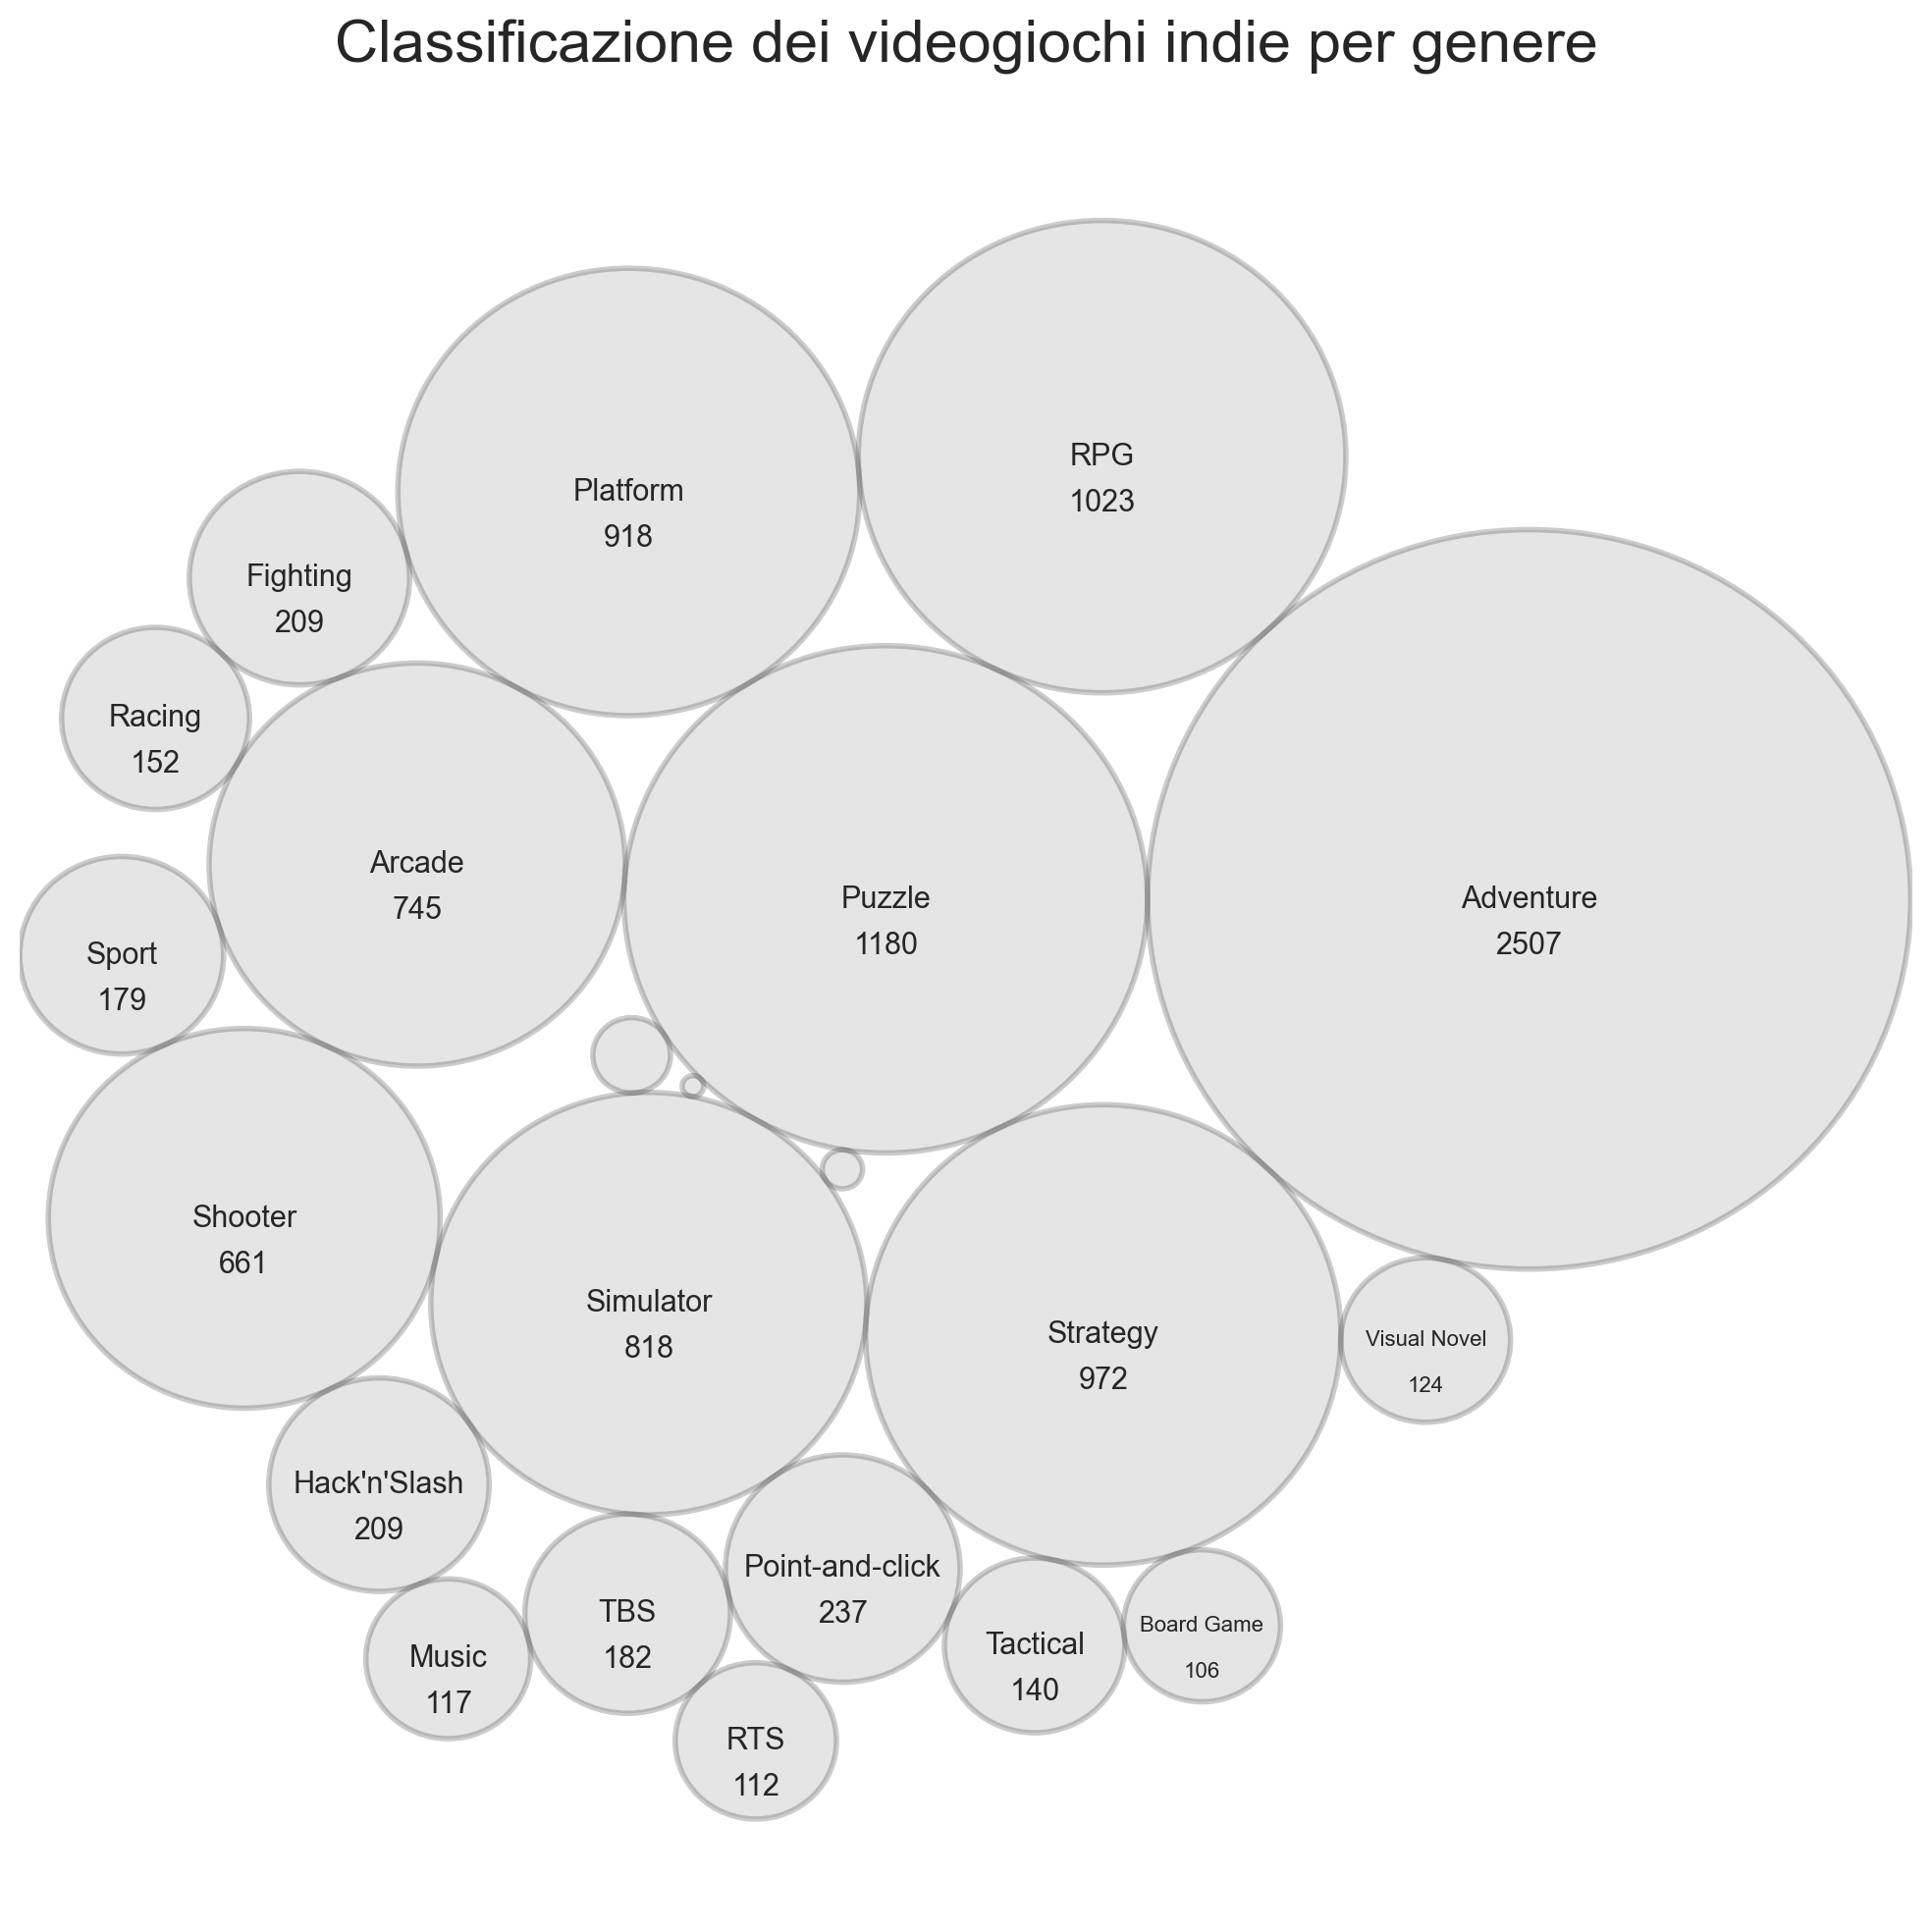

In [44]:
import circlify
igdb_df_indie = igdb_df['genres']
igdb_df_indie = igdb_df_indie[igdb_df_indie.apply(lambda x: 32 in x)]

igdb_df_indie_exploded = igdb_df_indie.explode('genres')

genre_counts = igdb_df_indie_exploded.value_counts().reset_index(name='count')
# Non considero "indie" come genere
genre_counts = genre_counts[genre_counts['genres'] != 32]

circles = circlify.circlify(
    genre_counts['count'].tolist(),
    show_enclosure=False,
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)
# Inverto l'ordine (partire dall'inizio fino alla fine e andare di passo -1)
circles = circles[::-1]

fig, ax = plt.subplots(figsize=(10,10),dpi=200)

ax.set_title('Classificazione dei videogiochi indie per genere', fontsize=22)
ax.axis('off')

# Limiti degli assi
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# print circles
for circle, index in zip(circles, genre_counts.index):
    x, y, r = circle
    row = genre_counts.loc[index]
    value = row['count']
    label = igdb_genres_map[row['genres']]
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2,
                 edgecolor="black", facecolor="gray"))
    fontsize = 11
    if(label in ['Board Game', 'Visual Novel']):
        fontsize = 8

    if (value > 30):
        ax.annotate(
            label,
            (x, y),
            va='center',
            ha='center',
            fontsize=fontsize,
        )
        ax.annotate(
            value,
            (x, y-0.05),
            ha='center',
            va='center',
            fontsize=fontsize,
        )
plt.tight_layout()
plt.show()
#fig.savefig("imgs/grafici/fig2.png")

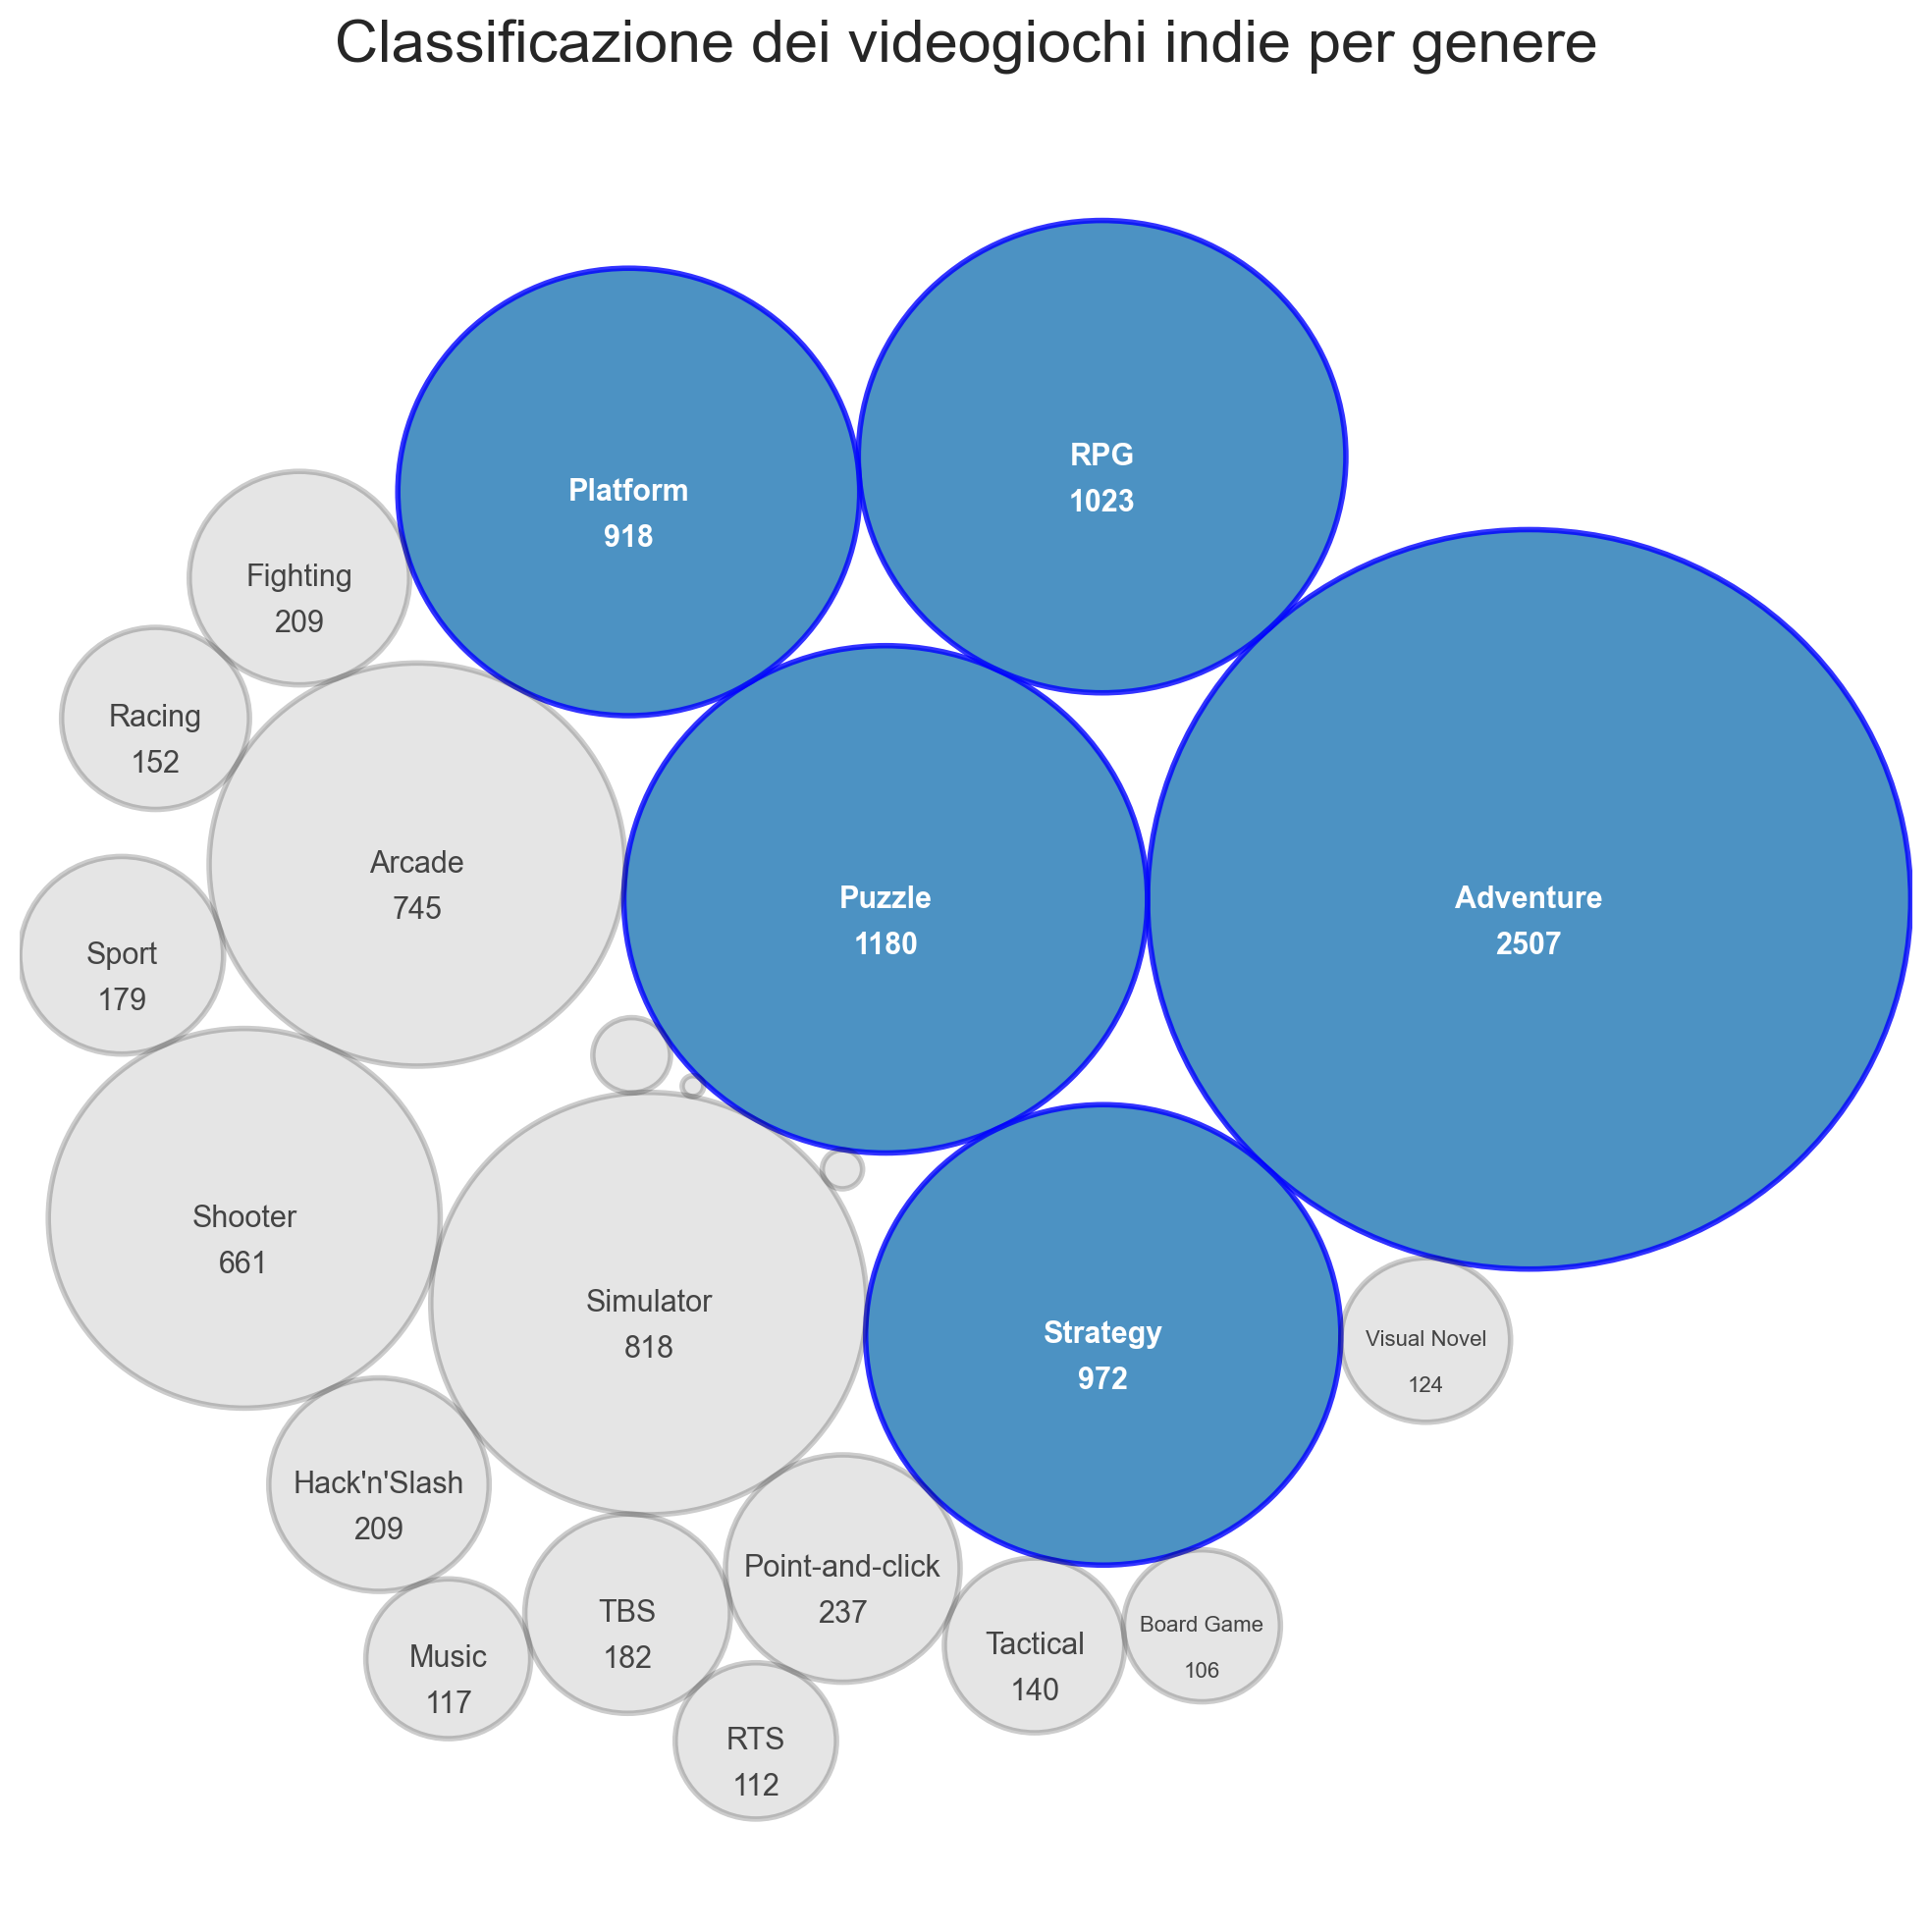

In [45]:
import circlify
igdb_df_indie = igdb_df['genres']
igdb_df_indie = igdb_df_indie[igdb_df_indie.apply(lambda x: 32 in x)]

igdb_df_indie_exploded = igdb_df_indie.explode('genres')

genre_counts = igdb_df_indie_exploded.value_counts().reset_index(name='count')
# Non considero "indie" come genere
genre_counts = genre_counts[genre_counts['genres'] != 32]
genre_counts_ordered = genre_counts.sort_values(by='count', ascending=False)
top_5_labels = genre_counts_ordered.head(5)['genres'].tolist()

circles = circlify.circlify(
    genre_counts['count'].tolist(),
    show_enclosure=False,
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)
# Inverto l'ordine (partire dall'inizio fino alla fine e andare di passo -1)
circles = circles[::-1]

fig, ax = plt.subplots(figsize=(10,10),dpi=200)

ax.set_title('Classificazione dei videogiochi indie per genere', fontsize=22)
ax.axis('off')

# Limiti degli assi
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# print circles
for circle, index in zip(circles, genre_counts.index):
    x, y, r = circle
    row = genre_counts.loc[index]
    value = row['count']
    label = igdb_genres_map[row['genres']]

    facecolor = "gray"
    edgecolor = "black"
    alpha = 0.2;
    textcolor = "black"
    weight = "normal"
    fontsize = 11
    textalpha = 0.7

    if row['genres'] in top_5_labels:
        facecolor = "tab:blue"
        edgecolor = "blue"
        alpha = 0.8
        textcolor = "white"
        weight = "bold"
        textalpha = 1

    ax.add_patch(plt.Circle((x, y), r, alpha=alpha, linewidth=2,
                 edgecolor=edgecolor, facecolor=facecolor))
   

    if(label in ['Board Game', 'Visual Novel']):
        fontsize = 8

    if (value > 30):
        ax.annotate(
            label,
            (x, y),
            va='center',
            ha='center',
            fontsize=fontsize,
            color=textcolor,
            weight=weight,
            alpha=textalpha,
        )
        ax.annotate(
            value,
            (x, y-0.05),
            ha='center',
            va='center',
            fontsize=fontsize,
            color=textcolor,
            weight=weight,
            alpha=textalpha
        )
plt.tight_layout()
plt.show()
#fig.savefig("imgs/grafici/fig3.png")

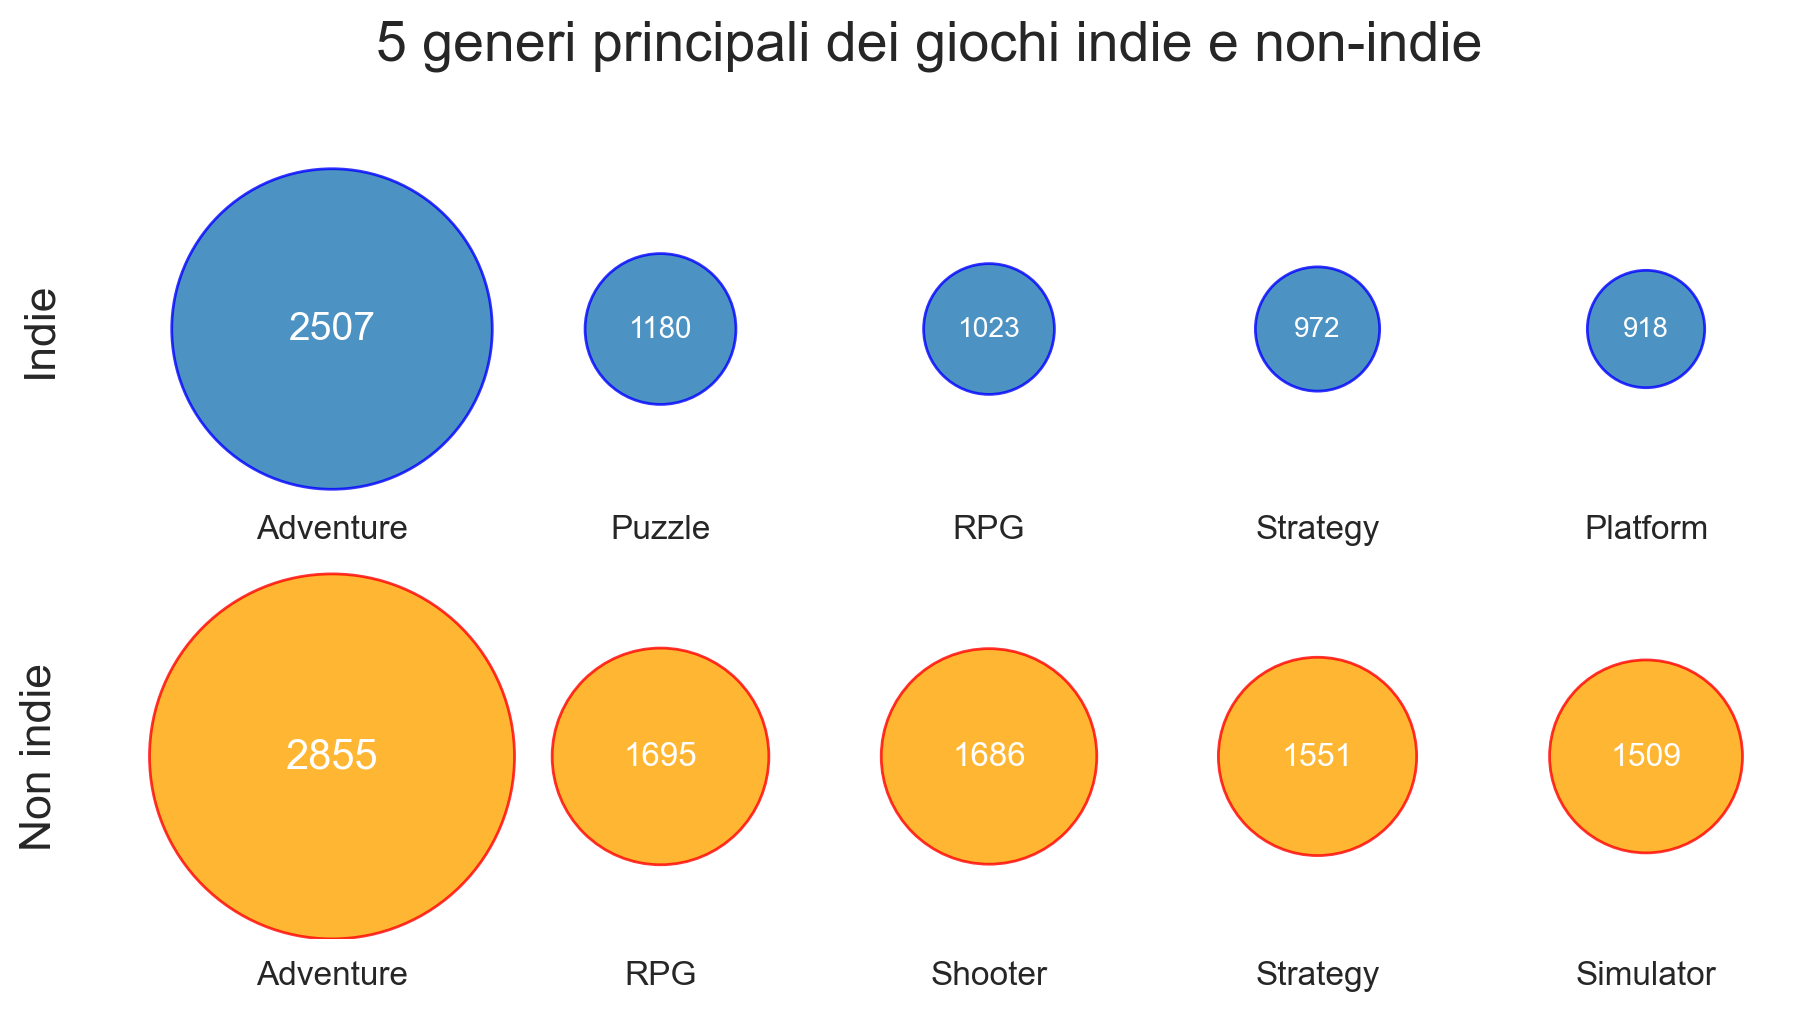

In [46]:
def top_5(df,skip_genres=[]):
    df_exploded = df.explode('genres')
    genre_counts = df_exploded.value_counts().reset_index(name='count')
    for skip_genre in skip_genres:
        genre_counts = genre_counts[genre_counts['genres'] != skip_genre]
    return genre_counts.sort_values(by='count', ascending=False).head(5)

igdb_df_indie = igdb_df['genres']
igdb_df_indie = igdb_df_indie[igdb_df_indie.apply(lambda x: 32 in x)]

igdb_df_not_indie = igdb_df['genres']
igdb_df_not_indie = igdb_df_not_indie[igdb_df_not_indie.apply(lambda x: 32 not in x)]

top_5_indie = top_5(igdb_df_indie,[32])
top_5_not_indie = top_5(igdb_df_not_indie)

max_value = max(top_5_indie['count'].iloc[0], top_5_not_indie['count'].iloc[0])

top_5_indie['size'] = top_5_indie['count'] / max_value
top_5_not_indie['size'] = top_5_not_indie['count'] / max_value

top_5_indie['facecolor'] = "tab:blue"
top_5_not_indie['facecolor'] = "orange"

top_5_indie['edgecolor'] = "blue"
top_5_not_indie['edgecolor'] = "red"

top_5_indie['genres'] = top_5_indie['genres'].apply(lambda x: igdb_genres_map[x])
top_5_not_indie['genres'] = top_5_not_indie['genres'].apply(lambda x: igdb_genres_map[x])


sns.set_theme(style="white")
fig, (ax_i, ax_ni) = plt.subplots(2, 1, figsize=(10,5),dpi=200)

def draw_circles(ax, df, y_text):
    x = 0
    for index, row in df.iterrows():
        label = row['genres']
        size = row['size']
        facecolor = row['facecolor']
        edgecolor = row['edgecolor']
        circle = plt.Circle((x, 0), size/2, facecolor=facecolor, edgecolor=edgecolor, linewidth=1, alpha=0.8)
        ax.add_artist(circle)
        ax.text(x, -y_text, label, ha='center', va='center', fontsize=12)
        ax.text(x, 0, f"{row['count']}", ha='center', va='center', fontsize=15*(0.5 + (size * 0.5)), color="white")
        x += 0.9

draw_circles(ax_i, top_5_indie,0.55)
draw_circles(ax_ni, top_5_not_indie,0.6)

for ax in [ax_i, ax_ni]:
    ax.set_xlim(-0.6, 4)
    ax.set_ylim(-0.5, 0.51)
    ax.set_aspect('equal')
    ax.axis('off')

ax_i.text(-0.8, 0, "Indie", rotation=90, va='center', ha='center', fontsize=16)
ax_ni.text(-0.8, 0, "Non indie", rotation=90, va='center', ha='center', fontsize=16)
    
fig.suptitle("5 generi principali dei giochi indie e non-indie", fontsize=20, y=1, x=0.51)
plt.tight_layout()
plt.show()
#fig.savefig("imgs/grafici/fig4.png")

C:\Users\Giovanni\AppData\Local\Temp\ipykernel_12488\3688495572.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_engines['game_engines'] = game_engines['game_engines'].replace(439,6) # Unisco Unreal Engine 4  in Unreal Engine
C:\Users\Giovanni\AppData\Local\Temp\ipykernel_12488\3688495572.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_engines['game_engines'] = top_5_engines['game_engines'].map(id_to_name)


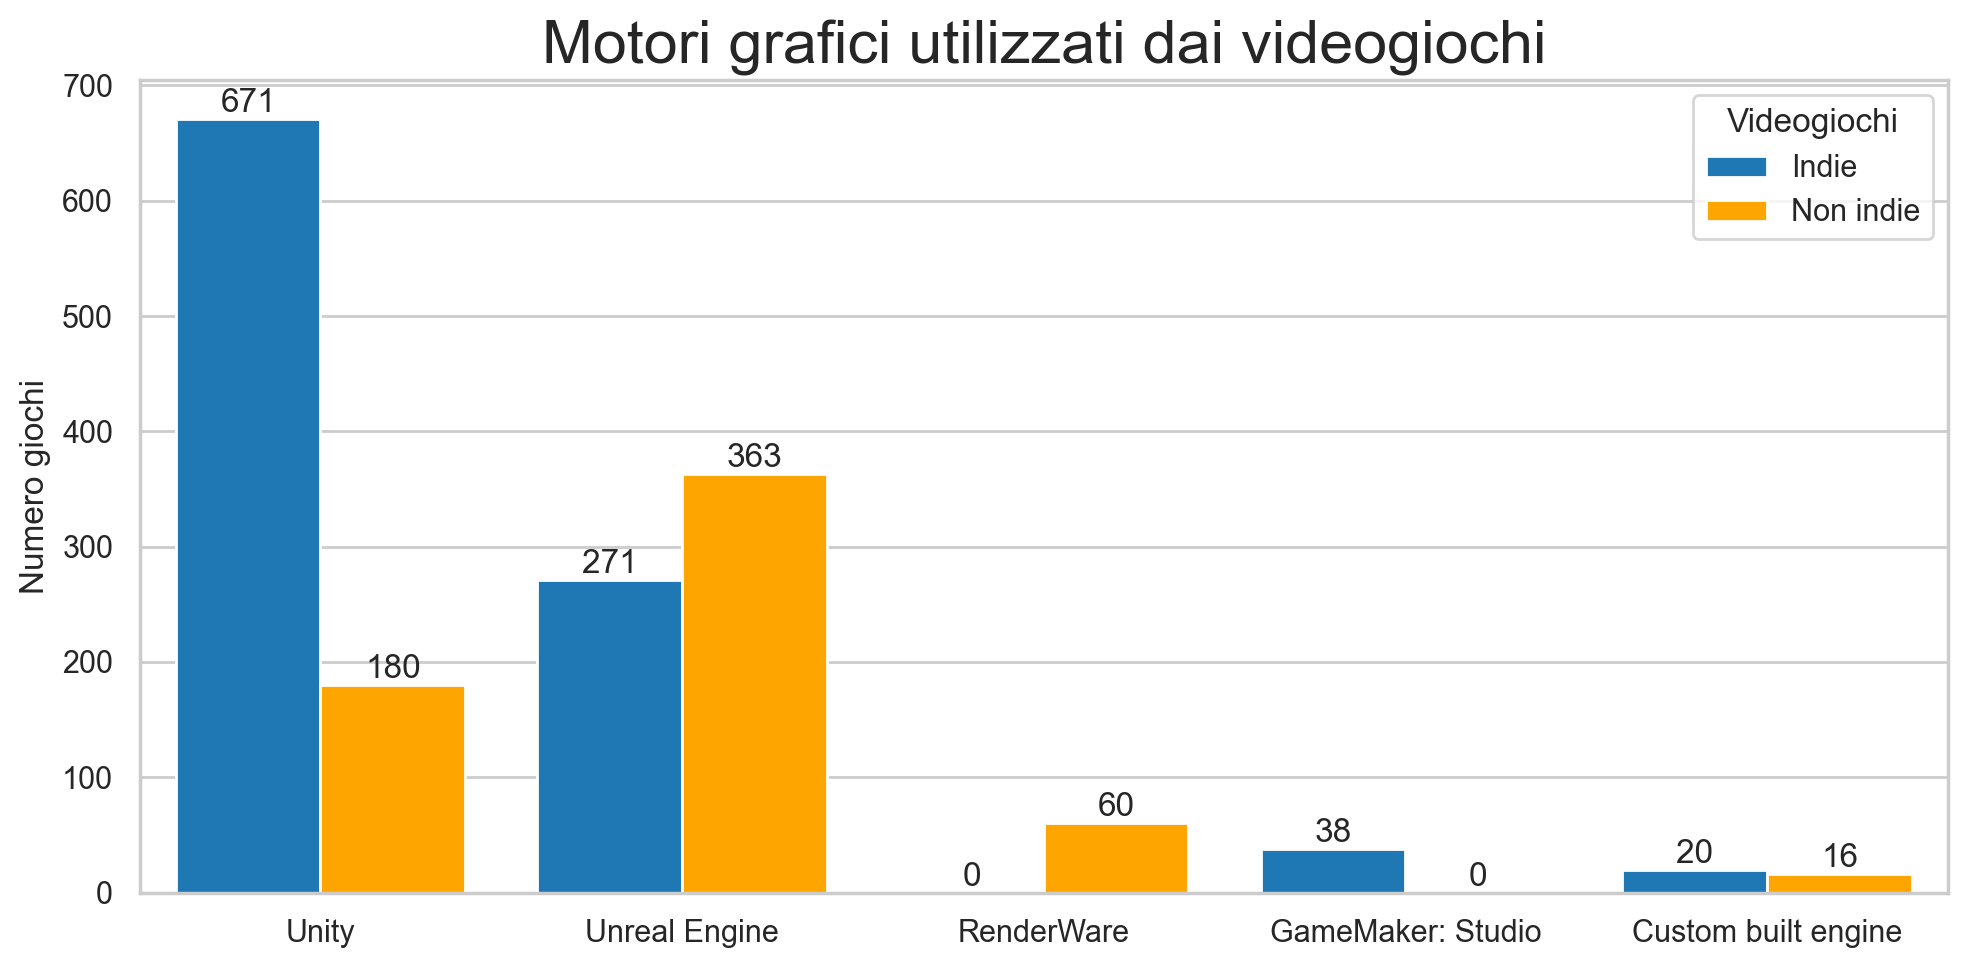

<Figure size 3600x1200 with 0 Axes>

In [53]:
# igdb_game_engines = igdb_wrapper.fetch_all_game_engines()

all_game_engines = pd.read_csv("data/igdb_game_engines.csv")
id_to_name = dict(zip(all_game_engines['id'], all_game_engines['name']))

game_engines = pd.DataFrame()
game_engines['indie'] = igdb_df['genres'].apply(lambda x: 32 in x)
game_engines['game_engines'] = igdb_df['game_engines'].apply(utils.str_to_list)
game_engines = game_engines.explode('game_engines').reset_index(drop=True)
game_engines['game_engines'] = game_engines['game_engines'].replace(439,6) # Unisco Unreal Engine 4  in Unreal Engine
game_engines['game_engines'] = game_engines['game_engines'].replace(351,6) # Unisco Unreal Engine 3 in Unreal Engine
#game_engines['game_engines'] = game_engines['game_engines'].fillna(0)

ge_count = game_engines.groupby(['game_engines', 'indie']).size().unstack(fill_value=0) # Diventa un multi-index (game_engines, indie e non indie, size)
ge_count.columns = ['non_indie', 'indie']
ge_count['total'] = ge_count['non_indie'] + ge_count['indie'] # Aggiungo la colonna total
ge_count = ge_count.reset_index()
ge_count = ge_count.sort_values('total', ascending=False) # Ordino per la colonna total


sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5),dpi=200)

top_5_engines = ge_count.head(5)
top_5_engines['game_engines'] = top_5_engines['game_engines'].map(id_to_name)
plot_data = pd.melt(top_5_engines, 
                    id_vars=['game_engines'], 
                    value_vars=['indie', 'non_indie'],
                    var_name='type', value_name='count')

colors = {'indie': 'tab:blue', 'non_indie': 'orange'}
ax = sns.barplot(x='game_engines', y='count', hue='type', data=plot_data, order=top_5_engines['game_engines'].tolist(), palette=colors, saturation=1)

ax.set_title('Motori grafici utilizzati dai videogiochi', fontsize=22)
ax.set( xlabel="", ylabel='Numero giochi')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Indie', 'Non indie'], title='Videogiochi', title_fontsize='12', loc='upper right')

for i in plt.gca().containers:
    plt.gca().bar_label(i, label_type='edge')

fig = plt.gcf()
plt.tight_layout()
plt.show()
plt.draw()
#fig.savefig("imgs/grafici/fig5.png")

# Andamento dei videogiochi indie
[//]: # (Grafico che mostra il numero di giochi indie ogni mese, confrontato con giochi AAA)

C:\Users\Giovanni\AppData\Local\Temp\ipykernel_12488\2419322504.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels)


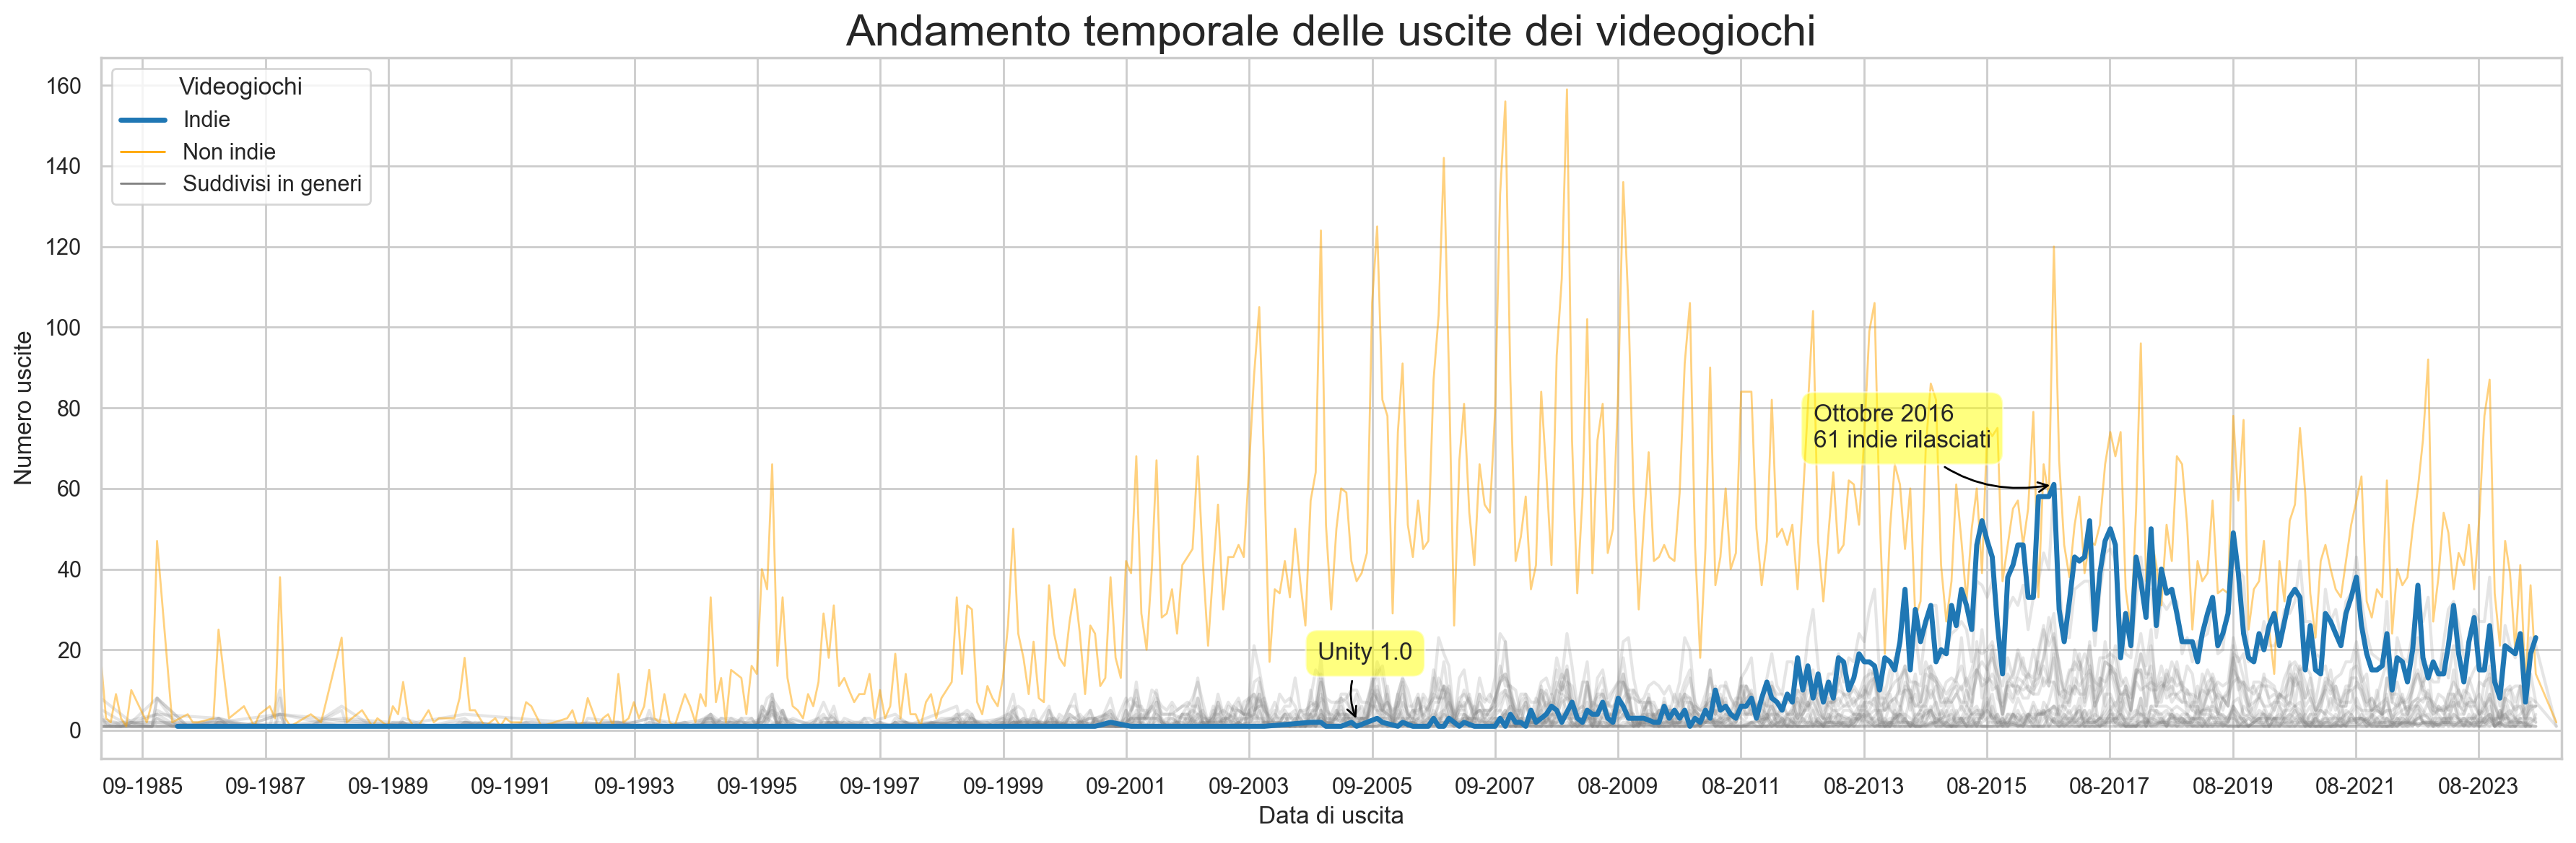

<Figure size 3600x1200 with 0 Axes>

In [47]:
df_month = igdb_df
df_month['year_month'] = df_month['first_release_date'].dt.to_period('M')
df_month = df_month.explode('genres')

df_indie = df_month[df_month['genres'] == 32]
df_not_indie = df_month[~df_month['name'].isin(df_indie['name'])] # IMPORTANTE: Escludo i giochi indie

games_per_month_indie = df_indie.groupby('year_month').size().reset_index(name='count')
games_per_month_indie['year_month'] = games_per_month_indie['year_month'].dt.to_timestamp().apply(lambda date: date.toordinal())

games_per_month_not_indie = df_not_indie.groupby(['genres', 'year_month']).size().reset_index(name='count')
games_per_month_not_indie['year_month'] = games_per_month_not_indie['year_month'].dt.to_timestamp().apply(lambda date: date.toordinal())

sns.set_theme(rc={'figure.figsize':(18,6), 'figure.dpi':200})
sns.set_style("whitegrid")

ax = sns.lineplot(
    data=games_per_month_indie,
    x='year_month', 
    y='count',
    zorder=3,
    linewidth=2.5,
    legend=True,
    color='tab:blue'
)

not_indie = df_not_indie.groupby('year_month').size().reset_index(name='count')
not_indie['year_month'] = not_indie['year_month'].dt.to_timestamp().apply(lambda date: date.toordinal())
sns.lineplot(
    data=not_indie,
    x='year_month', 
    y='count',
    zorder=2,
    linewidth=1,
    color='orange',
    ax = ax,
    alpha = 0.5,
    legend=True
)


games_per_month_all = df_month.groupby(['genres', 'year_month']).size().reset_index(name='count')
games_per_month_all['year_month'] = games_per_month_all['year_month'].dt.to_timestamp().apply(lambda date: date.toordinal())
for genre, group in games_per_month_all.groupby('genres'):
    sns.lineplot(
            data=group,
            x='year_month',
            y='count',
            ax = ax,
            color='gray',
            alpha=0.2,
            zorder=1
        )
    
plt.annotate('Ottobre 2016\n61 indie rilasciati',
             xy=(pd.Timestamp('2016-10-01').toordinal(), 61),
             xytext=(-120, 40),
             textcoords='offset points',
             ha='left',
             va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='black'))

plt.annotate('Unity 1.0',
             xy=(pd.Timestamp('2005-06-08').toordinal(), 2),
             xytext=(-20, 40),
             textcoords='offset points',
             ha='left',
             va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='black'))

ax.set_title('Andamento temporale delle uscite dei videogiochi',fontsize=22)
ax.set(
    xlabel="Data di uscita", 
    ylabel="Numero uscite",
xlim=(pd.Timestamp('1985-01-01').toordinal(), pd.Timestamp('2025-01-01').toordinal())
)

ax.xaxis.set_major_locator(ticker.MultipleLocator(730))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


labels = [date.fromordinal(int(ordinaldate)).strftime("%m-%Y") for ordinaldate in ax.get_xticks()]
ax.set(xticklabels=labels)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=2.5),
                Line2D([0], [0], color='orange', lw=1),
                Line2D([0], [0], color='gray', lw=1)]

plt.legend(custom_lines, ['Indie', 'Non indie', "Suddivisi in generi"], loc='upper left', title="Videogiochi")

fig = plt.gcf()
plt.tight_layout()
plt.show()
plt.draw()
#fig.savefig("imgs/grafici/fig6.png")


C:\Users\Giovanni\AppData\Local\Temp\ipykernel_12488\98913251.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels)


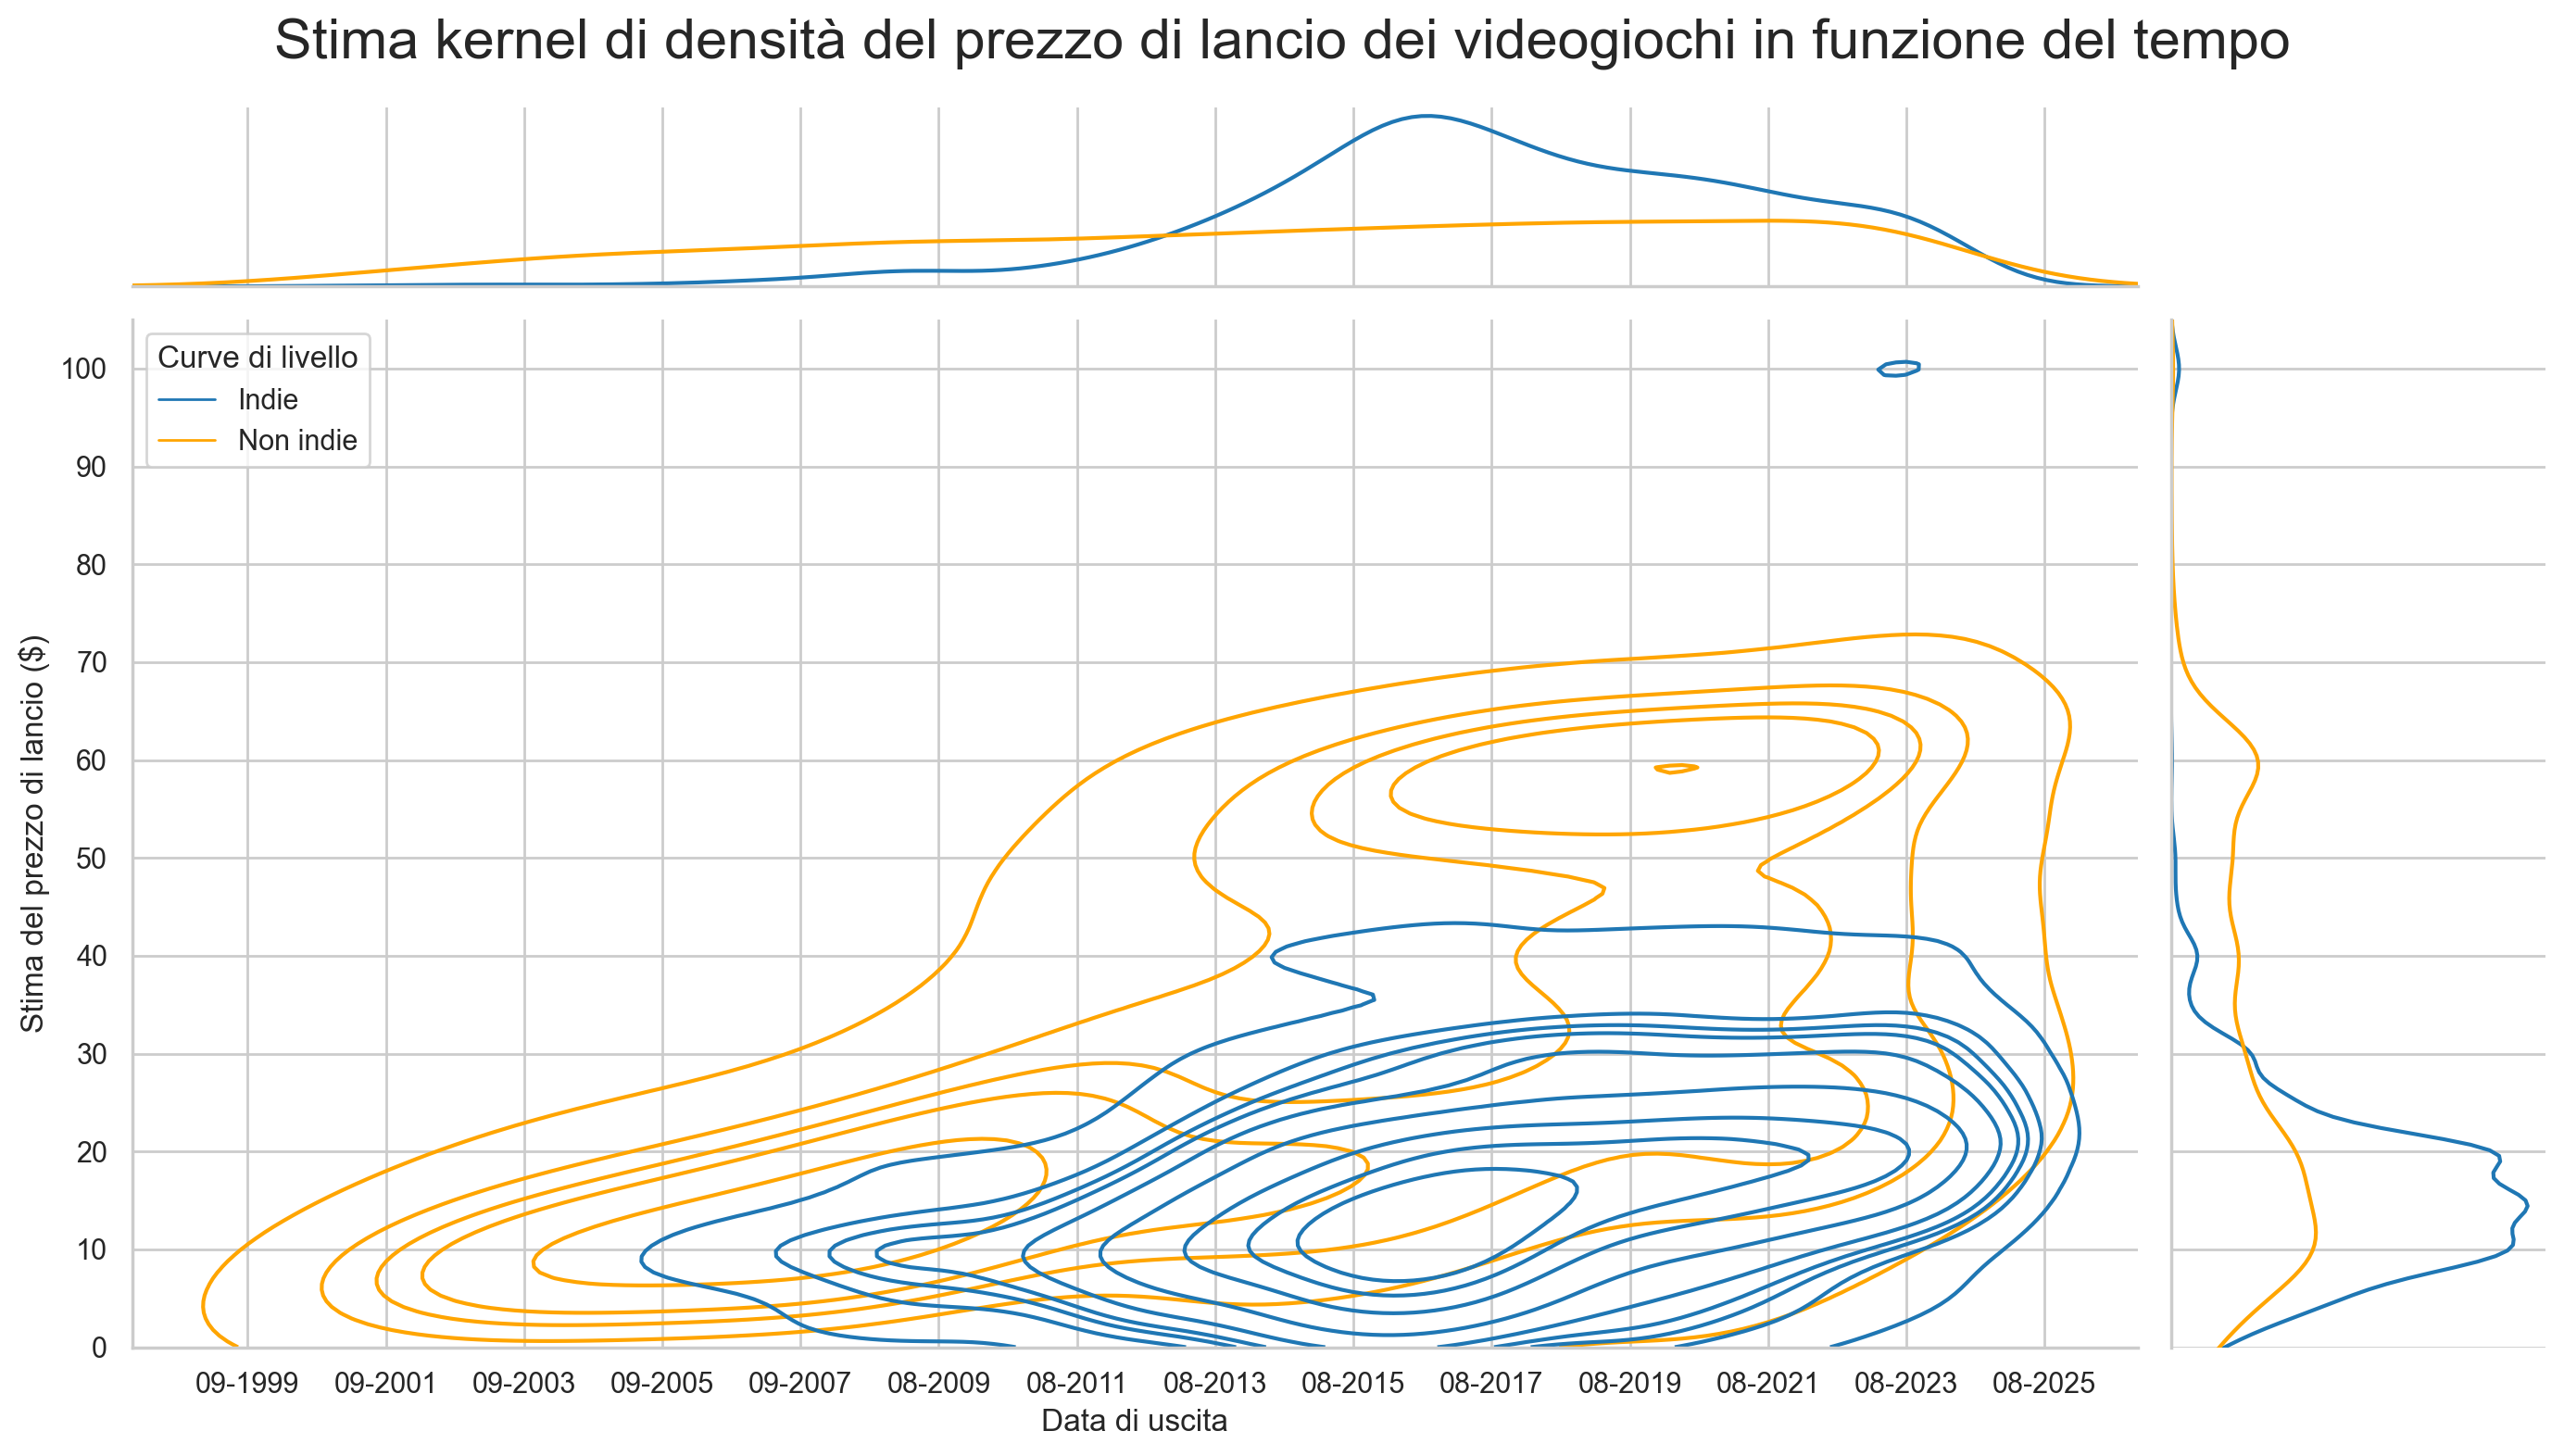

In [48]:
itad_df = pd.read_csv("data/itad.csv").drop_duplicates()
itad_df['genres'] = itad_df['genres'].apply(utils.str_to_list)
itad_df['first_release_date'] = pd.to_datetime(itad_df['first_release_date']).apply(lambda date: date.toordinal())
itad_df = itad_df[itad_df['release_price'] < 200]
itad_df['indie'] = itad_df['genres'].apply(lambda x: 1 if 32 in x else 0)

sns.set_style("whitegrid")

color_palette = {
    0: 'orange',
    1: 'tab:blue'
}
g = sns.jointplot(data=itad_df, x="first_release_date", y="release_price", hue="indie", kind="kde", palette=color_palette,  height=8, joint_kws={
    'clip': ((None, None), (0, None))
})
ax = g.ax_joint

g.figure.set_figwidth(14)
g.figure.set_figheight(8)

g.set_axis_labels('Data di uscita', 'Stima del prezzo di lancio ($)')

ax.set(
    ylim =(0,105),
xlim=(pd.Timestamp('1998-01-01').toordinal(), pd.Timestamp('2027-01-01').toordinal())
)

plt.suptitle('Stima kernel di densità del prezzo di lancio dei videogiochi in funzione del tempo',fontsize=22)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.set_major_locator(ticker.MultipleLocator(730))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

labels = [date.fromordinal(int(ordinaldate)).strftime("%m-%Y") for ordinaldate in ax.get_xticks()]
ax.set(xticklabels=labels)
custom_lines = [Line2D([0], [0], color='tab:blue', lw=1),
                Line2D([0], [0], color='orange', lw=1),]
plt.legend(custom_lines, ['Indie', 'Non indie'], loc='upper left', title="Curve di livello")
plt.tight_layout()
#plt.subplots_adjust(top=0.9) 
fig = plt.gcf()
#fig.savefig("imgs/grafici/fig7.png")


In [49]:
steam_df = pd.read_csv('data/games_may2024.csv')
igdb_websites = pd.read_csv('data/igdb_websites.csv')

C:\Users\Giovanni\AppData\Local\Temp\ipykernel_12488\3061234552.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels)


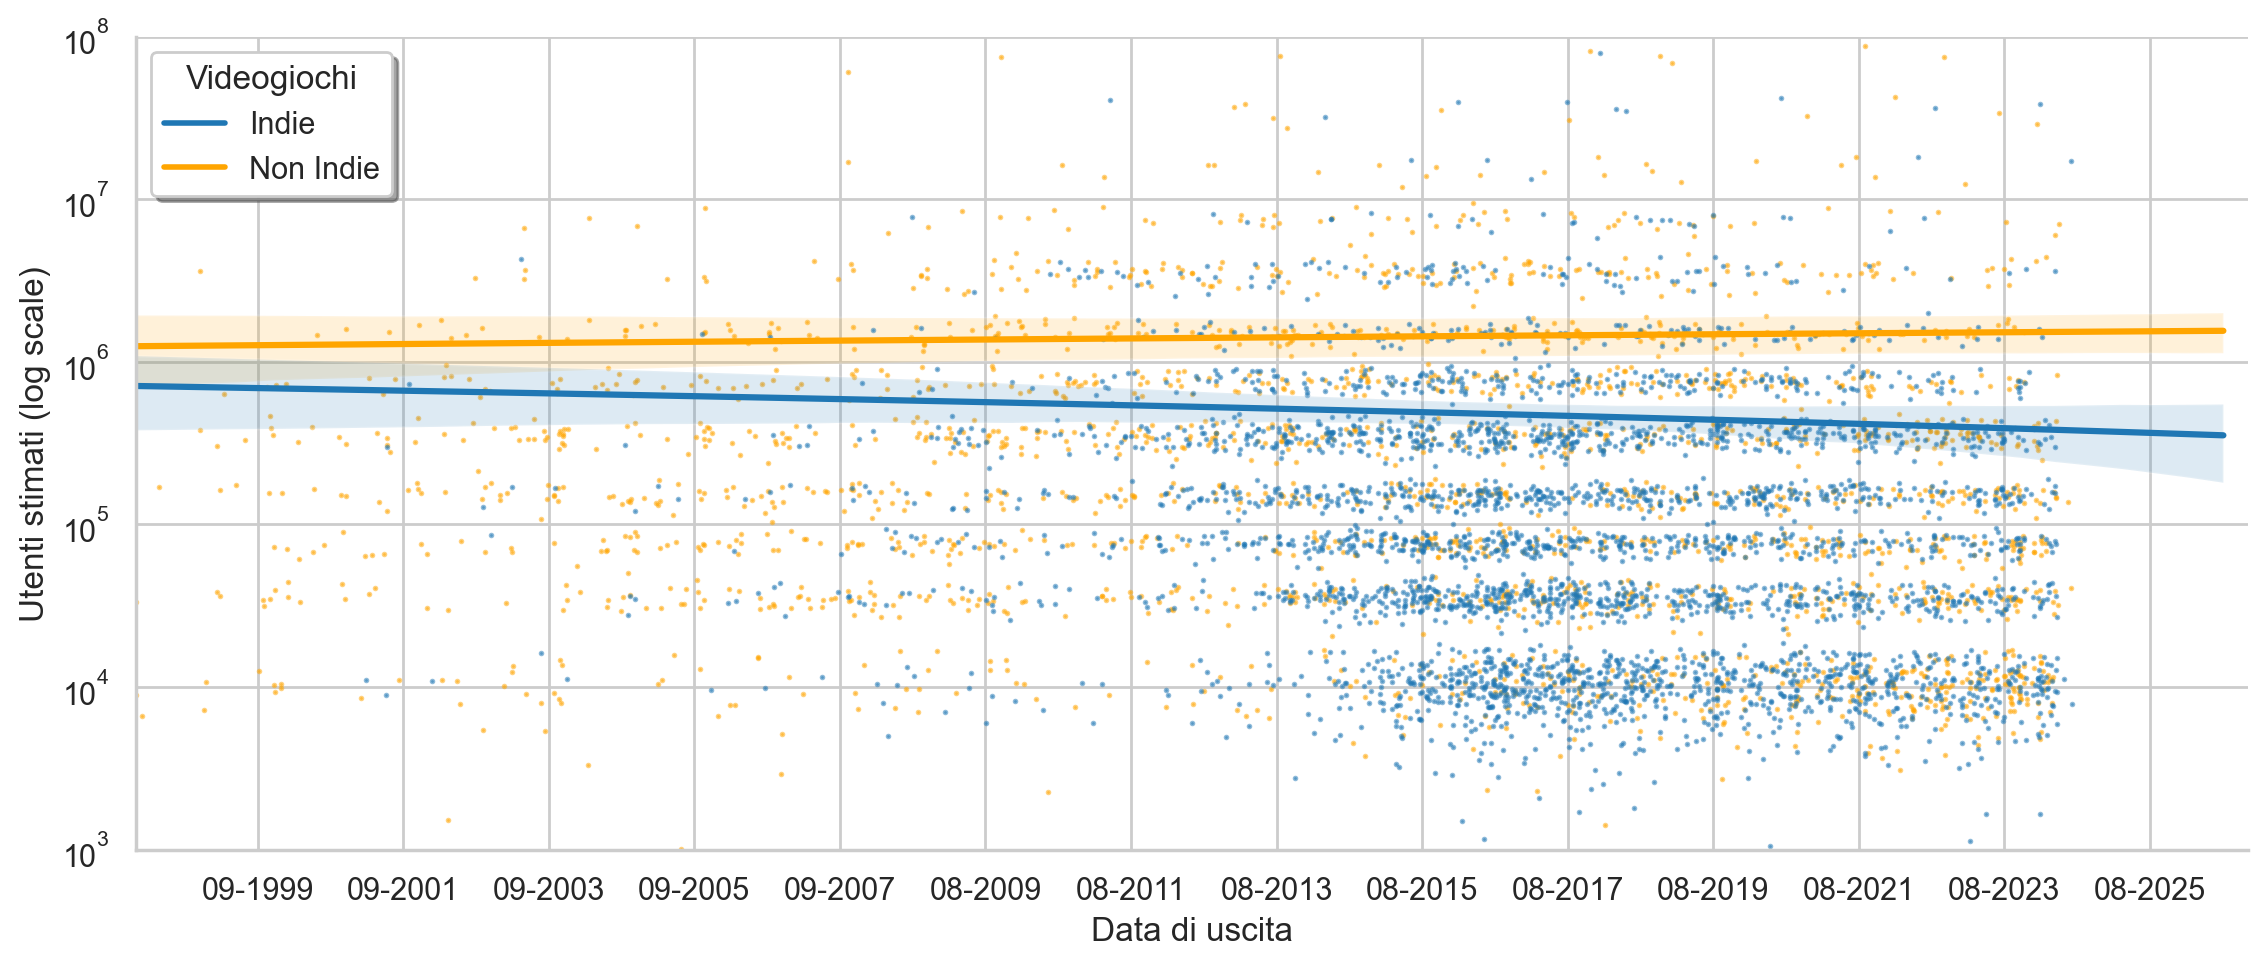

In [40]:
igdb_websites = igdb_websites[igdb_websites['category']==13]
igdb_web_merged = pd.merge(igdb_df, igdb_websites, left_on='id', right_on='game', how='inner')
igdb_web_merged = igdb_web_merged[['genres','name','slug','first_release_date','url_y']]
igdb_web_merged.rename(columns={'url_y':'appid'}, inplace=True)

import re 
def get_appid(url):
    match = re.search(r'/app/(\d+)', url)
    if match:
        return match.group(1)
    return None

igdb_web_merged['appid'] = igdb_web_merged['appid'].apply(lambda x: get_appid(x))
igdb_web_merged['appid'] = pd.to_numeric(igdb_web_merged['appid'], errors='coerce')

steam_merged = pd.merge(steam_df, igdb_web_merged, left_on='AppID', right_on='appid', how='inner')
steam_merged = steam_merged[['positive', 'negative', 'first_release_date','pct_pos_total','estimated_owners','genres_y','name_y']]
steam_merged.rename(columns={'genres_y':'indie', 'name_y':'name'}, inplace=True)
steam_merged = steam_merged.dropna()
steam_merged['total_reviews'] = steam_merged['positive'] + steam_merged['negative']
steam_merged['first_release_date'] = pd.to_datetime(steam_merged['first_release_date']).apply(lambda date: date.toordinal())
steam_merged['indie'] = steam_merged['indie'].apply(lambda x: 1 if 32 in x else 0)

def random_from_range(range_string):
    start, end = map(int, range_string.split('-'))
    r = end-start
    media = (r/2)+start
    std_dev = (r/2)/3 # Uso la regola empirica, con 3 deviazioni standard, il 99,7% dei dati della gaussiana ricade nel range
    while True:
        number = np.random.normal(media, std_dev) # Mi assicuro che il numero random sia nel range, dovrebbe esserso, se non per il 0.3% dei dati
        if start <= number <= end:
            return int(round(number))

steam_merged['estimated_owners'] = steam_merged['estimated_owners'].apply(lambda x: random_from_range(x))
#steam_merged_indie = steam_merged[steam_merged['indie'] == 1]
color_palette = {
    0: 'orange',
    1: 'tab:blue'
}
g = sns.lmplot(x="first_release_date", 
               y="estimated_owners", 
               data=steam_merged, 
               height=5,
               aspect=2.3,
               hue="indie",
               palette=color_palette,
               legend=False,
               truncate=False,
               scatter_kws={'s': 1, 'alpha': 0.5},
               )
g.set_axis_labels("Data di uscita", "Utenti stimati (log scale)")
ax = g.axes[0, 0] 
ax.set_yscale('log')

custom_lines = [Line2D([0], [0], color='tab:blue', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
ax.legend(custom_lines, ['Indie', 'Non Indie'],
          title="Videogiochi",
          loc="upper left",
          bbox_to_anchor=(0, 1),
          bbox_transform=ax.transAxes,
          frameon=True,
          fancybox=True,
          shadow=True)

ax.set(
xlim=(pd.Timestamp('1998-01-01').toordinal(), pd.Timestamp('2027-01-01').toordinal())
)
ax.xaxis.set_major_locator(ticker.MultipleLocator(730))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_ylim(pow(10,3), pow(10,8))

labels = [date.fromordinal(int(ordinaldate)).strftime("%m-%Y") for ordinaldate in ax.get_xticks()]
ax.set(xticklabels=labels)

plt.tight_layout()
plt.show()
g.figure.savefig("imgs/grafici/fig8.png",dpi=200)

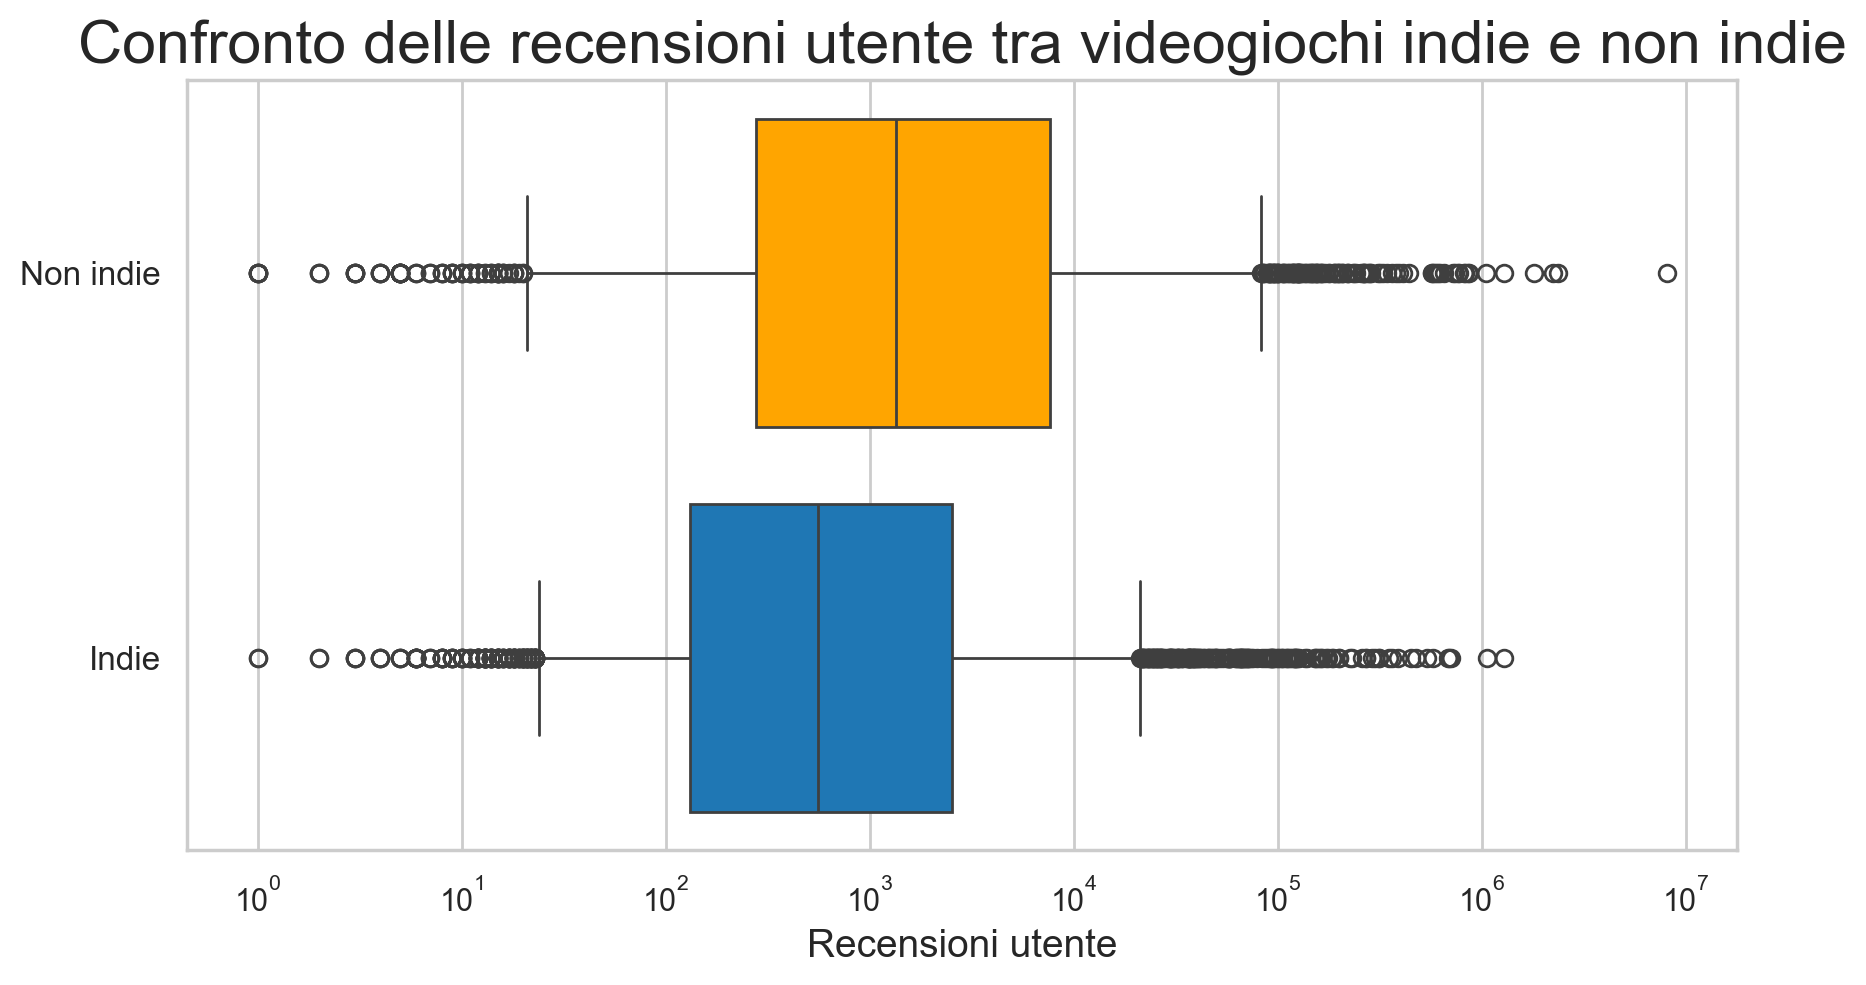

In [52]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
custom_palette = ['orange', 'tab:blue']
g = sns.boxplot(y='indie', hue='indie', x='total_reviews', orient='h', data=steam_merged, whis=[5, 95], palette=custom_palette, saturation=1, legend=False) #whis è la lunghezza dei baffi

plt.title('Confronto delle recensioni utente tra videogiochi indie e non indie', fontsize=22)
plt.ylabel('')
plt.xlabel('Recensioni utente', fontsize=14)
plt.yticks([0, 1], ['Non indie', 'Indie'], fontsize=12)

plt.xscale('log')

plt.show()
# g.figure.savefig("imgs/grafici/fig9.png",dpi=200)